In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

dataset = fetch_california_housing()
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['price'] = dataset.target

df.sample(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
14906,2.7014,33.0,4.076577,0.923423,989.0,4.454955,32.60,-117.06,1.08200
14118,3.8864,27.0,5.163399,1.024510,1628.0,2.660131,32.73,-117.11,1.32600
16522,5.1930,8.0,6.255814,0.990033,999.0,3.318937,37.81,-121.21,1.72100
8540,3.1325,27.0,4.378086,1.055556,2141.0,3.304012,33.89,-118.36,2.15000
7178,3.3333,41.0,3.422222,1.088889,814.0,4.522222,34.05,-118.18,1.15100
9384,6.0238,23.0,4.910714,1.199405,541.0,1.610119,37.89,-122.49,5.00001
6816,3.6696,40.0,5.230769,1.079670,1183.0,3.250000,34.10,-118.09,2.10400
1752,2.1991,15.0,4.158333,1.100641,3408.0,2.184615,37.96,-122.34,1.33300
381,3.4844,46.0,4.876777,0.857820,567.0,2.687204,37.74,-122.16,1.29500
18487,5.1519,15.0,5.067019,0.964727,1582.0,2.790123,37.01,-121.58,2.64700


Let's perform EDA. First, let's look at the features values

In [2]:
print(f'length of dataset: {df.shape[0]}', end='\n\n')
print(df.describe())

length of dataset: 20640

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude         price  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min   

There are no gaps in the data, all features are numerical

Let's look at the correlation matrix

<Axes: >

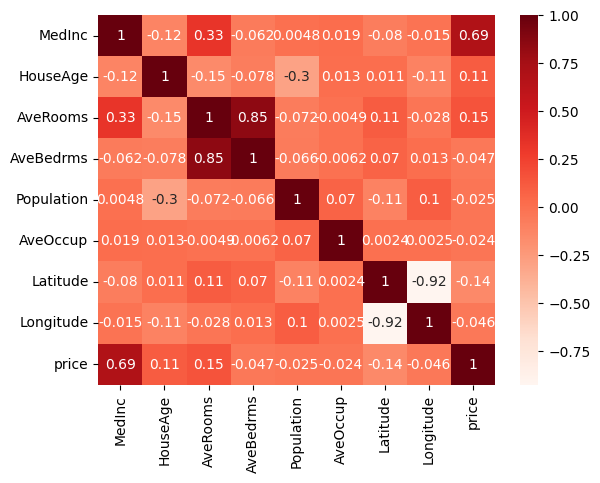

In [3]:
import seaborn as sns
sns.heatmap(df.corr(), cmap='Reds', annot=True)

Let's also consider the mutual distribution of features

<Figure size 3200x1800 with 0 Axes>

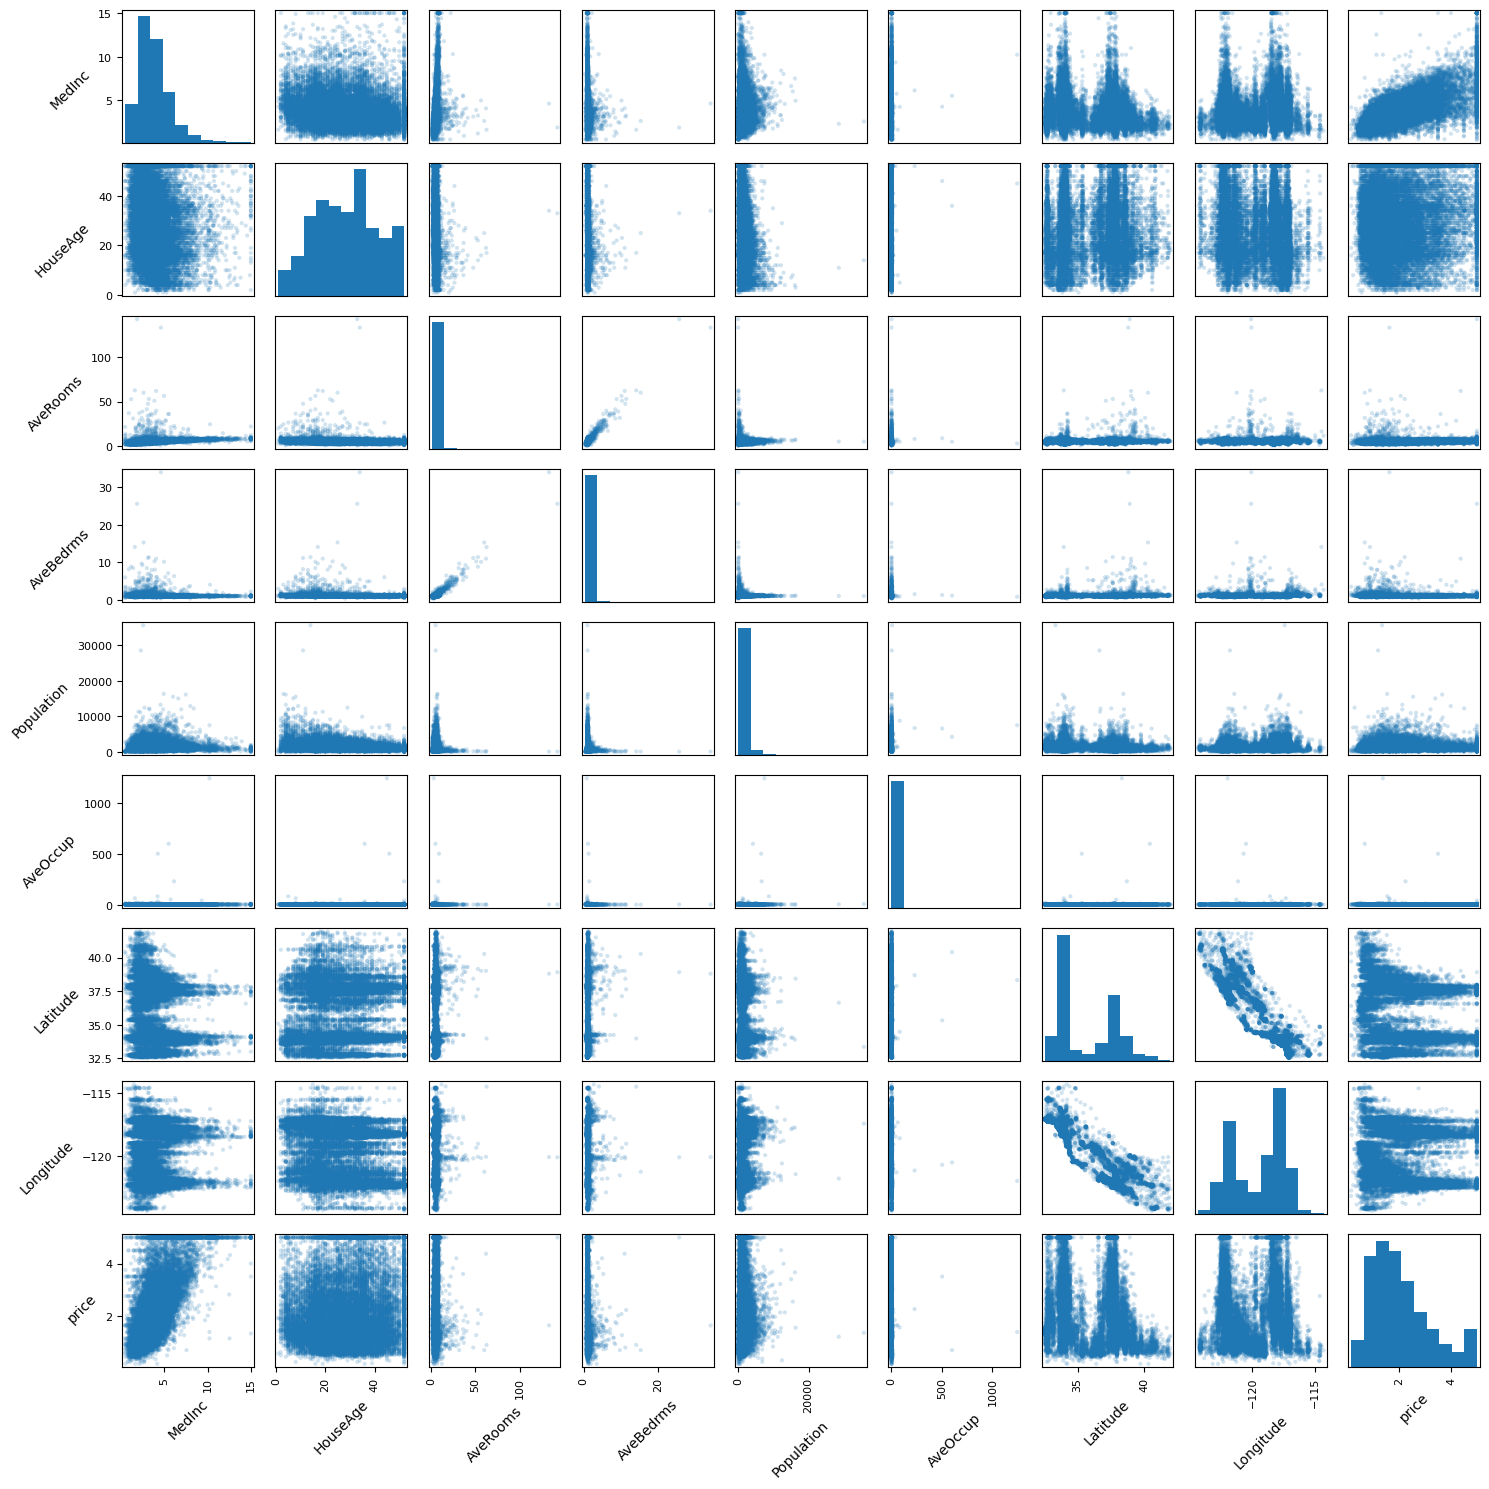

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(32, 18))

axes = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(15, 15))

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.show()

We will use the decision tree model for the following reasons
1. There is a very small linear dependence between the features and the target variable
2. The distribution shows a low functional dependence
3. There is a linear dependence between the features themselves, but it is not strict, so I want to use all of them for prediction without creating a multicollinearity problem

Let's create a function that will train, validate, and test an ensemble of models

In [5]:
import optuna
from datetime import datetime

def get_estimate_info(objective, n_trials):
    start = datetime.now()
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    return {'best_params': study.best_params, 'time': str(datetime.now() - start)}

Create dataframe for collecting testing data

In [6]:
testing_data = pd.DataFrame()

In [7]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X, Y = df.drop(columns=['price']), df['price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# My AdaBoostRegressor

In [8]:
import ada_boost_regressor

def objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 1, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    
    base_model = DecisionTreeRegressor(
        criterion=criterion, 
        splitter=splitter, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )

    n_estimators = trial.suggest_int('n_estimators', 2, 5)
    model = ada_boost_regressor.AdaBoostRegressor(base_estimator=base_model, n_estimators=n_estimators)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return score.mean()

estimate_info = get_estimate_info(objective, 5)
params = estimate_info['best_params']

base_model = DecisionTreeRegressor(
    criterion=params['criterion'],
    splitter=params['splitter'],
    max_depth=params['max_depth'],
    min_samples_split=params['min_samples_split'],
    min_samples_leaf=params['min_samples_leaf']
)
model = ada_boost_regressor.AdaBoostRegressor(base_estimator=base_model, n_estimators=params['n_estimators'])
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

testing_data = testing_data.append({
    'name': 'My AdaBoostRegressor', 
    'R2': r2_score(y_test, y_predicted), 
    'MSE': mean_squared_error(y_test, y_predicted),
    'MAE': mean_absolute_error(y_test, y_predicted),
    'time': estimate_info['time']
}, ignore_index=True)

testing_data

[I 2024-04-08 09:44:24,616] A new study created in memory with name: no-name-6ebe0a8f-8316-400c-8fcb-b2c0812a9460
[I 2024-04-08 09:44:26,051] Trial 0 finished with value: -0.6335859184116408 and parameters: {'criterion': 'squared_error', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 2}. Best is trial 0 with value: -0.6335859184116408.
[I 2024-04-08 09:44:26,578] Trial 1 finished with value: -0.5744253412005887 and parameters: {'criterion': 'friedman_mse', 'splitter': 'random', 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 4, 'n_estimators': 5}. Best is trial 1 with value: -0.5744253412005887.
[I 2024-04-08 09:46:00,223] Trial 2 finished with value: -0.6110838393310254 and parameters: {'criterion': 'absolute_error', 'splitter': 'best', 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 3}. Best is trial 1 with value: -0.5744253412005887.
[I 2024-04-08 09:46:00,351] Trial 3 finished with val

,name,R2,MSE,MAE,time
0,My AdaBoostRegressor,0.735543,0.346546,0.391876,0:01:38.555630


In [9]:
import bagging_regressor

def objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 1, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    
    base_model = DecisionTreeRegressor(
        criterion=criterion, 
        splitter=splitter, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )

    n_estimators = trial.suggest_int('n_estimators', 2, 5)
    model = bagging_regressor.BaggingRegressor(base_model=base_model, n_estimators=n_estimators)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return score.mean()

estimate_info = get_estimate_info(objective, 5)
params = estimate_info['best_params']

base_model = DecisionTreeRegressor(
    criterion=params['criterion'],
    splitter=params['splitter'],
    max_depth=params['max_depth'],
    min_samples_split=params['min_samples_split'],
    min_samples_leaf=params['min_samples_leaf']
)
model = bagging_regressor.BaggingRegressor(base_model=base_model, n_estimators=params['n_estimators'])
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

testing_data = testing_data.append({
    'name': 'My BaggingRegressor', 
    'R2': r2_score(y_test, y_predicted), 
    'MSE': mean_squared_error(y_test, y_predicted),
    'MAE': mean_absolute_error(y_test, y_predicted),
    'time': estimate_info['time']
}, ignore_index=True)

testing_data

[I 2024-04-08 09:46:29,661] A new study created in memory with name: no-name-1e53ba97-a08e-481b-a27c-0e27cc9103e2
[I 2024-04-08 09:47:06,293] Trial 0 finished with value: -0.9550325507843394 and parameters: {'criterion': 'absolute_error', 'splitter': 'best', 'max_depth': 1, 'min_samples_split': 4, 'min_samples_leaf': 2, 'n_estimators': 4}. Best is trial 0 with value: -0.9550325507843394.
[I 2024-04-08 09:47:07,175] Trial 1 finished with value: -0.6783586607058297 and parameters: {'criterion': 'friedman_mse', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5, 'n_estimators': 4}. Best is trial 1 with value: -0.6783586607058297.
[I 2024-04-08 09:47:26,720] Trial 2 finished with value: -0.7860003513036451 and parameters: {'criterion': 'absolute_error', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 2}. Best is trial 1 with value: -0.6783586607058297.
[I 2024-04-08 09:47:27,041] Trial 3 finished with value

,name,R2,MSE,MAE,time
0,My AdaBoostRegressor,0.735543,0.346546,0.391876,0:01:38.555630
1,My BaggingRegressor,0.761758,0.312194,0.366246,0:00:59.255540


In [11]:
import optuna
import sklearn.ensemble as skl

def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 1, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    
    base_model = DecisionTreeRegressor(
        criterion=criterion, 
        splitter=splitter, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    n_estimators = trial.suggest_int('n_estimators', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1)

    model = skl.AdaBoostRegressor(estimator=base_model, n_estimators=n_estimators, learning_rate=learning_rate)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return score.mean()

estimate_info = get_estimate_info(objective, 5)
params = estimate_info['best_params']

base_model = DecisionTreeRegressor(
    criterion=params['criterion'],
    splitter=params['splitter'],
    max_depth=params['max_depth'],
    min_samples_split=params['min_samples_split'],
    min_samples_leaf=params['min_samples_leaf']
)
model = skl.AdaBoostRegressor(
    estimator=base_model, 
    n_estimators=params['n_estimators'], 
    learning_rate=params['learning_rate']
)
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

testing_data = testing_data.append({
    'name': 'sklearn.AdaBoostRegressor', 
    'R2': r2_score(y_test, y_predicted), 
    'MSE': mean_squared_error(y_test, y_predicted),
    'MAE': mean_absolute_error(y_test, y_predicted),
    'time': estimate_info['time']
}, ignore_index=True)

testing_data

[I 2024-04-08 09:57:07,210] A new study created in memory with name: no-name-b02809dc-4a22-4a4d-8bf7-54612ab7db86
[I 2024-04-08 09:57:12,354] Trial 0 finished with value: -0.5337209683206621 and parameters: {'criterion': 'friedman_mse', 'splitter': 'best', 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 4, 'n_estimators': 10, 'learning_rate': 0.7348440631732931}. Best is trial 0 with value: -0.5337209683206621.
[I 2024-04-08 09:57:15,416] Trial 1 finished with value: -0.5429417136699571 and parameters: {'criterion': 'squared_error', 'splitter': 'best', 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 3, 'n_estimators': 7, 'learning_rate': 0.9426667400183728}. Best is trial 0 with value: -0.5337209683206621.
[I 2024-04-08 09:57:17,227] Trial 2 finished with value: -0.5818079547198445 and parameters: {'criterion': 'squared_error', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 2, 'n_estimators': 5, 'learning_rate': 0.5006732822975

,name,R2,MSE,MAE,time
0,My AdaBoostRegressor,0.735543,0.346546,0.391876,0:01:38.555630
1,My BaggingRegressor,0.761758,0.312194,0.366246,0:00:59.255540
2,sklearn.AdaBoostRegressor,0.788271,0.277451,0.332368,0:01:47.898308


In [27]:
import optuna
import sklearn.ensemble as skl

def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 1, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    
    base_model = DecisionTreeRegressor(
        criterion=criterion, 
        splitter=splitter, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    n_estimators = trial.suggest_int('n_estimators', 1, 500)
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])

    model = skl.BaggingRegressor(
        estimator=base_model, 
        n_estimators=n_estimators, 
        max_samples=1.0, 
        max_features=max_features
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return score.mean()

estimate_info = get_estimate_info(objective, 5)
params = estimate_info['best_params']

base_model = DecisionTreeRegressor(
    criterion=params['criterion'],
    splitter=params['splitter'],
    max_depth=params['max_depth'],
    min_samples_split=params['min_samples_split'],
    min_samples_leaf=params['min_samples_leaf']
)
model = skl.BaggingRegressor(
    estimator=base_model, 
    n_estimators=params['n_estimators'], 
    max_features=params['max_features'],
    max_samples=1.0
)
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

testing_data = testing_data.append({
    'name': 'sklearn.BaggingRegressor', 
    'R2': r2_score(y_test, y_predicted), 
    'MSE': mean_squared_error(y_test, y_predicted),
    'MAE': mean_absolute_error(y_test, y_predicted),
    'time': estimate_info['time']
}, ignore_index=True)

testing_data

[I 2024-04-08 10:14:35,319] A new study created in memory with name: no-name-7927aec8-406d-4bbe-9354-a513e944ccdf
[I 2024-04-08 10:14:40,818] Trial 0 finished with value: -0.778146206983308 and parameters: {'criterion': 'friedman_mse', 'splitter': 'random', 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 310, 'max_features': 4}. Best is trial 0 with value: -0.778146206983308.
[I 2024-04-08 10:14:45,196] Trial 1 finished with value: -0.776059614253014 and parameters: {'criterion': 'friedman_mse', 'splitter': 'random', 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'n_estimators': 243, 'max_features': 5}. Best is trial 1 with value: -0.776059614253014.
[I 2024-04-08 10:14:53,899] Trial 2 finished with value: -0.6509808028405191 and parameters: {'criterion': 'squared_error', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 5, 'n_estimators': 59, 'max_features': 3}. Best is trial 2 with value: -0.650980802840519

,name,R2,MSE,MAE,time
0,My AdaBoostRegressor,0.735543,0.346546,0.391876,0:01:38.555630
1,My BaggingRegressor,0.761758,0.312194,0.366246,0:00:59.255540
2,sklearn.AdaBoostRegressor,0.788271,0.277451,0.332368,0:01:47.898308
3,sklearn.BaggingRegressor,0.780561,0.287554,0.373708,0:00:33.077998


In [29]:
import optuna
import sklearn.ensemble as skl

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    model = skl.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean() 

estimate_info = get_estimate_info(objective, 5)
params = estimate_info['best_params']

model = skl.RandomForestRegressor(
    n_estimators=params['n_estimators'], 
    max_depth=params['max_depth'],
    min_samples_split=params['min_samples_split'],
    min_samples_leaf=params['min_samples_leaf']
)
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

testing_data = testing_data.append({
    'name': 'sklearn.RandomForestRegressor', 
    'R2': r2_score(y_test, y_predicted), 
    'MSE': mean_squared_error(y_test, y_predicted),
    'MAE': mean_absolute_error(y_test, y_predicted),
    'time': estimate_info['time']
}, ignore_index=True)

testing_data

[I 2024-04-08 10:24:55,359] A new study created in memory with name: no-name-2dfb5ac6-7476-404d-84ce-32f2929bbba8
[I 2024-04-08 10:25:05,652] Trial 0 finished with value: -0.5100771481849046 and parameters: {'n_estimators': 78, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: -0.5100771481849046.
[I 2024-04-08 10:25:33,395] Trial 1 finished with value: -0.262836881888284 and parameters: {'n_estimators': 65, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: -0.262836881888284.
[I 2024-04-08 10:26:31,233] Trial 2 finished with value: -0.2673888182735597 and parameters: {'n_estimators': 170, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 1 with value: -0.262836881888284.
[I 2024-04-08 10:26:46,202] Trial 3 finished with value: -0.26877080931140995 and parameters: {'n_estimators': 41, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with valu

,name,R2,MSE,MAE,time
0,My AdaBoostRegressor,0.735543,0.346546,0.391876,0:01:38.555630
1,My BaggingRegressor,0.761758,0.312194,0.366246,0:00:59.255540
2,sklearn.AdaBoostRegressor,0.788271,0.277451,0.332368,0:01:47.898308
3,sklearn.BaggingRegressor,0.780561,0.287554,0.373708,0:00:33.077998
4,sklearn.RandomForestRegressor,0.807287,0.252532,0.326361,0:02:34.782934


In [30]:
import optuna
import sklearn.ensemble as skl

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1)

    model = skl.GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean() 

estimate_info = get_estimate_info(objective, 5)
params = estimate_info['best_params']

model = skl.GradientBoostingRegressor(
        n_estimators=params['n_estimators'], 
        max_depth=params['max_depth'], 
        learning_rate=params['learning_rate']
)
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

testing_data = testing_data.append({
    'name': 'sklearn.GradientBoostingRegressor', 
    'R2': r2_score(y_test, y_predicted), 
    'MSE': mean_squared_error(y_test, y_predicted),
    'MAE': mean_absolute_error(y_test, y_predicted),
    'time': estimate_info['time']
}, ignore_index=True)

testing_data

[I 2024-04-08 10:31:22,220] A new study created in memory with name: no-name-2606b4f6-01e1-456b-a19f-d5bd8abe96b5
[I 2024-04-08 10:32:47,394] Trial 0 finished with value: -0.33793780229717396 and parameters: {'n_estimators': 130, 'max_depth': 14, 'learning_rate': 0.5237777831463035}. Best is trial 0 with value: -0.33793780229717396.
[I 2024-04-08 10:33:46,360] Trial 1 finished with value: -0.4306655634553966 and parameters: {'n_estimators': 176, 'max_depth': 7, 'learning_rate': 0.9334248389036551}. Best is trial 0 with value: -0.33793780229717396.
[I 2024-04-08 10:36:03,022] Trial 2 finished with value: -0.4134495549118452 and parameters: {'n_estimators': 184, 'max_depth': 19, 'learning_rate': 0.07418648388943269}. Best is trial 0 with value: -0.33793780229717396.
[I 2024-04-08 10:36:26,582] Trial 3 finished with value: -0.4734798529904328 and parameters: {'n_estimators': 32, 'max_depth': 22, 'learning_rate': 0.2812277404793991}. Best is trial 0 with value: -0.33793780229717396.
[I 202

,name,R2,MSE,MAE,time
0,My AdaBoostRegressor,0.735543,0.346546,0.391876,0:01:38.555630
1,My BaggingRegressor,0.761758,0.312194,0.366246,0:00:59.255540
2,sklearn.AdaBoostRegressor,0.788271,0.277451,0.332368,0:01:47.898308
3,sklearn.BaggingRegressor,0.780561,0.287554,0.373708,0:00:33.077998
4,sklearn.RandomForestRegressor,0.807287,0.252532,0.326361,0:02:34.782934
5,sklearn.GradientBoostingRegressor,0.753923,0.322461,0.369476,0:07:08.217953


In [35]:
import optuna
import sklearn.ensemble as skl

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    model = skl.HistGradientBoostingRegressor(
        learning_rate=learning_rate, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean() 

estimate_info = get_estimate_info(objective, 10)
params = estimate_info['best_params']

model = skl.HistGradientBoostingRegressor(
        learning_rate=params['learning_rate'], 
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf']
)
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

testing_data = testing_data.append({
    'name': 'sklearn.HistGradientBoostingRegressor', 
    'R2': r2_score(y_test, y_predicted), 
    'MSE': mean_squared_error(y_test, y_predicted),
    'MAE': mean_absolute_error(y_test, y_predicted),
    'time': estimate_info['time']
}, ignore_index=True)

testing_data

[I 2024-04-08 10:44:53,353] A new study created in memory with name: no-name-79baf35f-7c8c-4bef-82bd-facd68fa5ecd
[I 2024-04-08 10:44:54,194] Trial 0 finished with value: -0.24040290108975132 and parameters: {'learning_rate': 0.3497582981110478, 'max_depth': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: -0.24040290108975132.
[I 2024-04-08 10:44:55,477] Trial 1 finished with value: -0.2428922284406631 and parameters: {'learning_rate': 0.05450787701709769, 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 0 with value: -0.24040290108975132.
[I 2024-04-08 10:44:56,757] Trial 2 finished with value: -0.3554134586851427 and parameters: {'learning_rate': 0.018497071628146226, 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 0 with value: -0.24040290108975132.
[I 2024-04-08 10:44:58,049] Trial 3 finished with value: -0.2818503357228411 and parameters: {'learning_rate': 0.02961617277529724, 'max_depth': 16, 'min_samples_leaf': 5}. Best is trial 0 with value: -0.2404029010897

,name,R2,MSE,MAE,time
0,My AdaBoostRegressor,0.735543,0.346546,0.391876,0:01:38.555630
1,My BaggingRegressor,0.761758,0.312194,0.366246,0:00:59.255540
2,sklearn.AdaBoostRegressor,0.788271,0.277451,0.332368,0:01:47.898308
3,sklearn.BaggingRegressor,0.780561,0.287554,0.373708,0:00:33.077998
4,sklearn.RandomForestRegressor,0.807287,0.252532,0.326361,0:02:34.782934
5,sklearn.GradientBoostingRegressor,0.753923,0.322461,0.369476,0:07:08.217953
6,sklearn.HistGradientBoostingRegressor,0.829839,0.222980,0.316595,0:00:10.501612


In [45]:
import optuna
import xgboost as xgb

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1, log=True)
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    
    model = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, booster=booster)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean() 

estimate_info = get_estimate_info(objective, 10)
params = estimate_info['best_params']

model = xgb.XGBRegressor(
    n_estimators=params['n_estimators'],
    learning_rate=params['learning_rate'], 
    booster=params['booster']
)
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

testing_data = testing_data.append({
    'name': 'XGBRegressor', 
    'R2': r2_score(y_test, y_predicted), 
    'MSE': mean_squared_error(y_test, y_predicted),
    'MAE': mean_absolute_error(y_test, y_predicted),
    'time': estimate_info['time']
}, ignore_index=True)

testing_data

[I 2024-04-08 11:19:07,480] A new study created in memory with name: no-name-1622341f-3409-4e80-b5e1-92e1e41aaf17
[I 2024-04-08 11:19:08,294] Trial 0 finished with value: -0.6814647060704968 and parameters: {'n_estimators': 295, 'learning_rate': 0.04844165317452156, 'booster': 'gblinear'}. Best is trial 0 with value: -0.6814647060704968.
[I 2024-04-08 11:19:08,461] Trial 1 finished with value: -0.6495305405939409 and parameters: {'n_estimators': 55, 'learning_rate': 0.6491672659871194, 'booster': 'gblinear'}. Best is trial 1 with value: -0.6495305405939409.
[I 2024-04-08 11:19:09,966] Trial 2 finished with value: -0.3237210317226973 and parameters: {'n_estimators': 290, 'learning_rate': 0.7895607644831193, 'booster': 'gbtree'}. Best is trial 2 with value: -0.3237210317226973.
[I 2024-04-08 11:19:10,288] Trial 3 finished with value: -0.23303547208303294 and parameters: {'n_estimators': 46, 'learning_rate': 0.2472087398350233, 'booster': 'gbtree'}. Best is trial 3 with value: -0.23303547

,name,R2,MSE,MAE,time
0,My AdaBoostRegressor,0.735543,0.346546,0.391876,0:01:38.555630
1,My BaggingRegressor,0.761758,0.312194,0.366246,0:00:59.255540
2,sklearn.AdaBoostRegressor,0.788271,0.277451,0.332368,0:01:47.898308
3,sklearn.BaggingRegressor,0.780561,0.287554,0.373708,0:00:33.077998
4,sklearn.RandomForestRegressor,0.807287,0.252532,0.326361,0:02:34.782934
5,sklearn.GradientBoostingRegressor,0.753923,0.322461,0.369476,0:07:08.217953
6,sklearn.HistGradientBoostingRegressor,0.829839,0.222980,0.316595,0:00:10.501612
7,XGBRegressor,0.836072,0.214813,0.304764,0:00:38.575126


In [53]:
import optuna
import lightgbm as lgb

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    num_leaves = trial.suggest_int('num_leaves', 2, 256)
    n_estimators = trial.suggest_int('n_estimators', 1, 500)

    model = lgb.LGBMRegressor(
        learning_rate=learning_rate, 
        max_depth=max_depth, 
        num_leaves=num_leaves, 
        n_estimators=n_estimators,
        verbose=-1
    )
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean() 

estimate_info = get_estimate_info(objective, 10)
params = estimate_info['best_params']

model = lgb.LGBMRegressor(
        learning_rate=params['learning_rate'], 
        max_depth=params['max_depth'], 
        num_leaves=params['num_leaves'], 
        n_estimators=params['n_estimators'],
        verbose=-1
)
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

testing_data = testing_data.append({
    'name': 'LGBMRegressor', 
    'R2': r2_score(y_test, y_predicted), 
    'MSE': mean_squared_error(y_test, y_predicted),
    'MAE': mean_absolute_error(y_test, y_predicted),
    'time': estimate_info['time']
}, ignore_index=True)

testing_data

[I 2024-04-08 11:26:51,846] A new study created in memory with name: no-name-a823cc7d-e2e6-4346-9f3f-b380686761f8
[I 2024-04-08 11:26:52,323] Trial 0 finished with value: -0.3833748304397132 and parameters: {'learning_rate': 0.016791102852089543, 'max_depth': 8, 'num_leaves': 12, 'n_estimators': 129}. Best is trial 0 with value: -0.3833748304397132.
[I 2024-04-08 11:26:53,094] Trial 1 finished with value: -0.2505316784941286 and parameters: {'learning_rate': 0.03288615958644663, 'max_depth': 7, 'num_leaves': 87, 'n_estimators': 120}. Best is trial 1 with value: -0.2505316784941286.
[I 2024-04-08 11:26:53,280] Trial 2 finished with value: -0.3924878166164499 and parameters: {'learning_rate': 0.04520007477581662, 'max_depth': 5, 'num_leaves': 115, 'n_estimators': 41}. Best is trial 1 with value: -0.2505316784941286.
[I 2024-04-08 11:26:54,602] Trial 3 finished with value: -0.2143542628002245 and parameters: {'learning_rate': 0.04855373816584674, 'max_depth': 6, 'num_leaves': 205, 'n_esti

,name,R2,MSE,MAE,time
0,My AdaBoostRegressor,0.735543,0.346546,0.391876,0:01:38.555630
1,My BaggingRegressor,0.761758,0.312194,0.366246,0:00:59.255540
2,sklearn.AdaBoostRegressor,0.788271,0.277451,0.332368,0:01:47.898308
3,sklearn.BaggingRegressor,0.780561,0.287554,0.373708,0:00:33.077998
4,sklearn.RandomForestRegressor,0.807287,0.252532,0.326361,0:02:34.782934
5,sklearn.GradientBoostingRegressor,0.753923,0.322461,0.369476,0:07:08.217953
6,sklearn.HistGradientBoostingRegressor,0.829839,0.222980,0.316595,0:00:10.501612
7,XGBRegressor,0.836072,0.214813,0.304764,0:00:38.575126
8,LGBMRegressor,0.844429,0.203861,0.299304,0:00:05.100968


In [57]:
import optuna
import catboost

def objective(trial):
    depth = trial.suggest_int('depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True)
    
    model = catboost.CatBoostRegressor(
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        verbose=False,
    )
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return score.mean() 

estimate_info = get_estimate_info(objective, 10)
params = estimate_info['best_params']

model = catboost.CatBoostRegressor(
        depth=params['depth'],
        learning_rate=params['learning_rate'],
        l2_leaf_reg=params['l2_leaf_reg'],
        verbose=False,
)
model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

testing_data = testing_data.append({
    'name': 'CatBoostRegressor', 
    'R2': r2_score(y_test, y_predicted), 
    'MSE': mean_squared_error(y_test, y_predicted),
    'MAE': mean_absolute_error(y_test, y_predicted),
    'time': estimate_info['time']
}, ignore_index=True)

testing_data

[I 2024-04-08 11:32:19,617] A new study created in memory with name: no-name-2fedf395-e3ec-454f-a7ea-7876e2b5a654
[I 2024-04-08 11:32:24,459] Trial 0 finished with value: -0.21458012540977706 and parameters: {'depth': 3, 'learning_rate': 0.29606781403964827, 'l2_leaf_reg': 0.022273562525634966}. Best is trial 0 with value: -0.21458012540977706.
[I 2024-04-08 11:32:29,466] Trial 1 finished with value: -0.21279636485835485 and parameters: {'depth': 3, 'learning_rate': 0.17379526903701076, 'l2_leaf_reg': 3.683217138110075}. Best is trial 1 with value: -0.21279636485835485.
[I 2024-04-08 11:32:48,317] Trial 2 finished with value: -0.21458463836744013 and parameters: {'depth': 8, 'learning_rate': 0.018428694325294242, 'l2_leaf_reg': 0.06651727785927472}. Best is trial 1 with value: -0.21279636485835485.
[I 2024-04-08 11:32:52,742] Trial 3 finished with value: -0.212513095286022 and parameters: {'depth': 3, 'learning_rate': 0.23848464932711527, 'l2_leaf_reg': 0.0010655831990177003}. Best is 

,name,R2,MSE,MAE,time
0,My AdaBoostRegressor,0.735543,0.346546,0.391876,0:01:38.555630
1,My BaggingRegressor,0.761758,0.312194,0.366246,0:00:59.255540
2,sklearn.AdaBoostRegressor,0.788271,0.277451,0.332368,0:01:47.898308
3,sklearn.BaggingRegressor,0.780561,0.287554,0.373708,0:00:33.077998
4,sklearn.RandomForestRegressor,0.807287,0.252532,0.326361,0:02:34.782934
5,sklearn.GradientBoostingRegressor,0.753923,0.322461,0.369476,0:07:08.217953
6,sklearn.HistGradientBoostingRegressor,0.829839,0.222980,0.316595,0:00:10.501612
7,XGBRegressor,0.836072,0.214813,0.304764,0:00:38.575126
8,LGBMRegressor,0.844429,0.203861,0.299304,0:00:05.100968
9,CatBoostRegressor,0.856763,0.187699,0.280785,0:01:57.387435


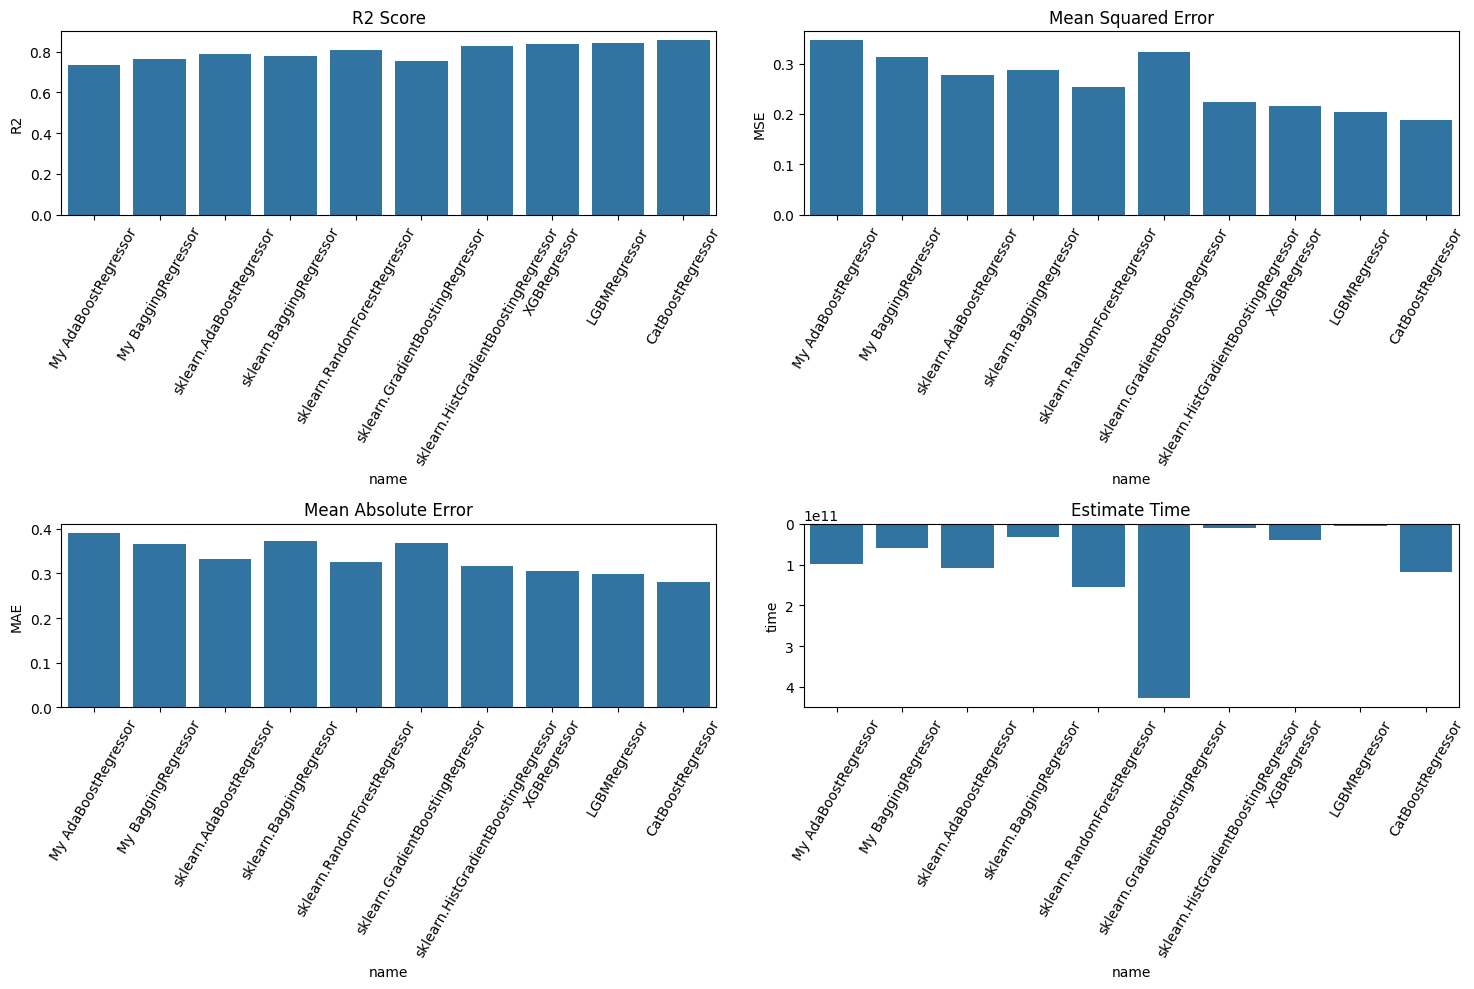

In [65]:
plt.figure(figsize=(15, 10))

testing_data['time'] = pd.to_timedelta(testing_data['time'])

plt.subplot(2, 2, 1)
sns.barplot(x='name', y='R2', data=testing_data).set_title('R2 Score')
plt.xticks(rotation=60) 

plt.subplot(2, 2, 2)
sns.barplot(x='name', y='MSE', data=testing_data).set_title('Mean Squared Error')
plt.xticks(rotation=60) 

plt.subplot(2, 2, 3)
sns.barplot(x='name', y='MAE', data=testing_data).set_title('Mean Absolute Error')
plt.xticks(rotation=60) 

plt.subplot(2, 2, 4)
sns.barplot(x='name', y='time', data=testing_data).set_title('Estimate Time')
plt.xticks(rotation=60) 
    
plt.tight_layout()
plt.show()